In [73]:
import os
import sys
import json
import random
import subprocess
from pathlib import Path

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(str(Path(os.getcwd()).parent))

from src import SGF_PATH, KATAGO_PATH
from src.utils.sgf_helper import get_moves, opponent

In [74]:
root_path = Path(os.getcwd()).parent
with open(root_path.joinpath("data/analysis.json")) as f:
    data = json.load(f)


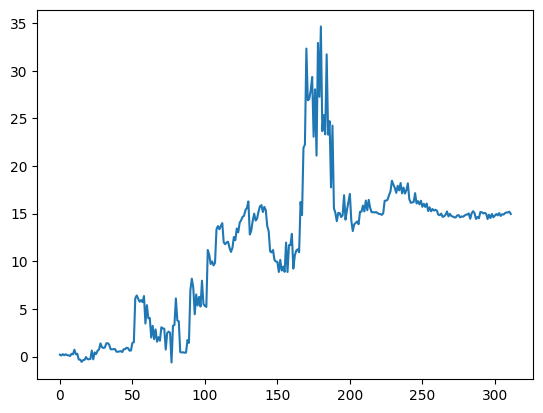

In [75]:
sgfname = "1.sgf"
game = data[sgfname]
game.sort(key=lambda m: m["turnNumber"])
plt.plot([m["rootInfo"]["scoreLead"] for m in game])

In [86]:
moves = get_moves(SGF_PATH.joinpath(f"selected_sgf/{sgfname}"))

In [89]:
start, amount = random.randint(0, len(moves) - 10), random.randint(4, 10)
start, amount

(29, 6)

In [90]:
selected_moves = moves[start : start + amount]
selected_moves

[('W', 'E16'),
 ('B', 'R10'),
 ('W', 'R3'),
 ('B', 'R2'),
 ('W', 'Q2'),
 ('B', 'P3')]

In [91]:
def possible_variations(
    moves: list[tuple[str, str]], current_player: str, branch: list = []
) -> list:
    if not moves:
        return [branch]

    variations = []
    player_moves = [move for move in moves if move[0] == current_player]

    for pm in player_moves:
        new_moves = [m for m in moves if m != pm]
        new_branch = branch + [pm]
        variations += possible_variations(
            new_moves, opponent(current_player), new_branch
        )

    return variations


next_player = selected_moves[0][0]
varations = possible_variations(selected_moves, next_player)
possible_games = [moves[:start] + v for v in varations]

In [92]:
len(varations)

36

In [93]:
def send_position_into_analysis(process, data: dict) -> None:
    # katago analyse requires input as oneline
    data_string = json.dumps(data).replace("\n", "") + "\n"
    process.stdin.write(data_string)
    process.stdin.flush()


model_path = str(KATAGO_PATH.joinpath("models", "b28c512nbt.bin.gz"))
config_path = str(KATAGO_PATH.joinpath("configs", "analysis_example.cfg"))

In [94]:
process = subprocess.Popen(
    ["katago", "analysis", "-config", config_path, "-model", model_path],
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True,
    bufsize=1,
)

results = {str(i): [] for i in range(len(possible_games))}
analyse_turns = [i for i in range(start, start + amount)]

for i, g in enumerate(possible_games):
    data = {
        "id": str(i),  # has to be string
        "initialStones": [],
        "moves": g,
        "rules": "tromp-taylor",
        "komi": 6.5,
        "boardXSize": 19,
        "boardYSize": 19,
        "analyzeTurns": analyse_turns,
    }
    send_position_into_analysis(process, data)


for i in tqdm(range(amount * len(possible_games))):
    while True:
        new_data = process.stdout.readline().strip()
        if new_data:
            result = json.loads(new_data)
            results[result["id"]].append(result)
            break

process.terminate()

100%|██████████| 216/216 [00:08<00:00, 26.22it/s]


In [95]:
diffs = [
    (
        k,
        abs(
            np.array([m["rootInfo"]["scoreLead"] for m in v])
            - np.array(
                [v[max(0, i - 1)]["rootInfo"]["scoreLead"] for i in range(len(v))]
            )
        ).mean(),
    )
    for k, v in results.items()
]

In [96]:
diffs.sort(key=lambda r: r[1])
diffs

[('2', np.float64(0.2011169813333333)),
 ('0', np.float64(0.31855783349999994)),
 ('3', np.float64(0.3788724536666667)),
 ('19', np.float64(0.41191487666666665)),
 ('16', np.float64(0.430740235)),
 ('29', np.float64(0.4338410383333334)),
 ('35', np.float64(0.6111246683333332)),
 ('28', np.float64(0.6220665866666667)),
 ('12', np.float64(0.6300141911666667)),
 ('31', np.float64(0.6543623700000002)),
 ('14', np.float64(0.6739220166666667)),
 ('24', np.float64(0.7463846633333334)),
 ('34', np.float64(0.7615531446666667)),
 ('22', np.float64(0.8313337036666667)),
 ('8', np.float64(1.0099525483333334)),
 ('25', np.float64(1.041546799)),
 ('1', np.float64(1.0485897203333332)),
 ('6', np.float64(1.0699569193333334)),
 ('23', np.float64(1.1196530983333333)),
 ('30', np.float64(1.1209251766666666)),
 ('17', np.float64(1.1741681403333333)),
 ('18', np.float64(1.1952812633333334)),
 ('4', np.float64(1.2093647976666666)),
 ('7', np.float64(1.2417277503333333)),
 ('9', np.float64(1.2542487061333334

<Figure size 1000x600 with 0 Axes>

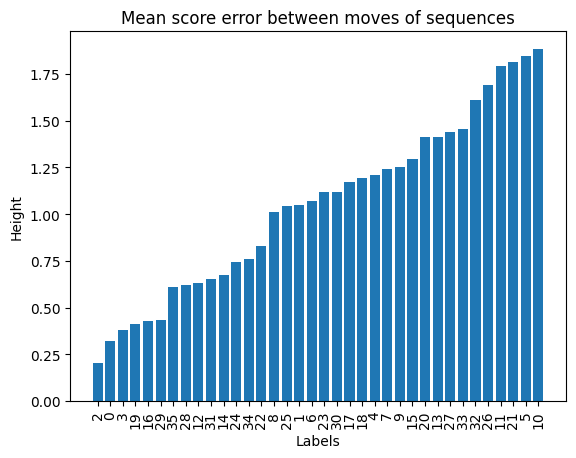

<Figure size 1000x600 with 0 Axes>

In [97]:
plt.bar([d[0] for d in diffs], [d[1] for d in diffs])
plt.xlabel("Labels")
plt.ylabel("Height")
plt.title("Mean score error between moves of sequences")

plt.xticks(rotation=90)
plt.figure(figsize=(10, 6))


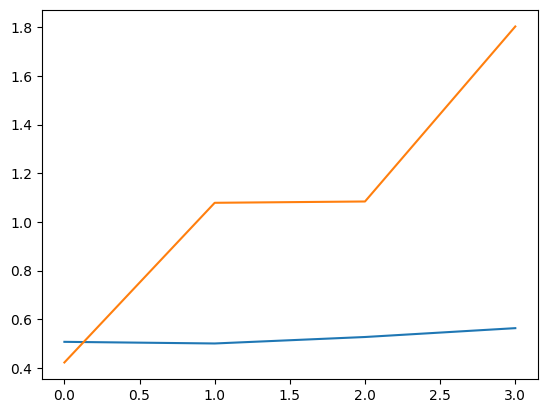

In [72]:
plt.plot([m["rootInfo"]["scoreLead"] for m in game[start : start + amount]])
plt.plot([m["rootInfo"]["scoreLead"] for m in results[str(10)]])